# Getting Started Code for [Chunin Exams Food Track- CV'2021](https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021) on AIcrowd
#### Author : Pulkit Gera

## Download Necessary Packages 📚

## Download Data
The first step is to download out train test data. We will be training a model on the train data and make predictions on test data. We submit our predictions.


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn import preprocessing
import pandas as pd
import os
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, TensorDataset, DataLoader

class FoodData(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def dispImg(self, item):
        if self.train:
            img_name,label = self.data_list.iloc[item]
        else:
            img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        plt.imshow(img)
    
    def __getitem__(self,item):
        if self.train:
            img_name,label = self.data_list.iloc[item]
        else:
            img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
            return {
              'gt' : img,
              'label' : torch.tensor(label)

          }
        else:
            return {
              'gt':img
          }

In [3]:
batch = 128
train_file = pd.read_csv('/content/drive/My Drive/train.csv')
test_file = pd.read_csv('/content/drive/My Drive/test.csv')
enc = preprocessing.LabelEncoder()
targets = enc.fit_transform(train_file['ClassName'])
train_path = "/content/drive/My Drive/train_images/train_images"
test_path = "/content/drive/My Drive/test_images/test_images"
train_images = []
test_images = []

In [4]:
def aug_transforms(option,test_file,test_path,trainFlag):
    if (option==1):
        transforms_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
        ])
    if (option==2):
        transforms_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5)),
            transforms.ColorJitter(),
            transforms.RandomRotation(10,fill=(0,)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(10,translate=(0.2,0.4))
        ])
    test_data = FoodData(data_list= test_file,data_dir = test_path,transform = transforms_test,train=trainFlag)
    
    return test_data
test_data = aug_transforms(1,test_file,test_path,False)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

In [5]:
ntrain = train_file
ntrain['ClassName'] = targets

train_data = aug_transforms(1,ntrain,train_path,True)

Percentage of each class
61 classes from a total of 9323 images


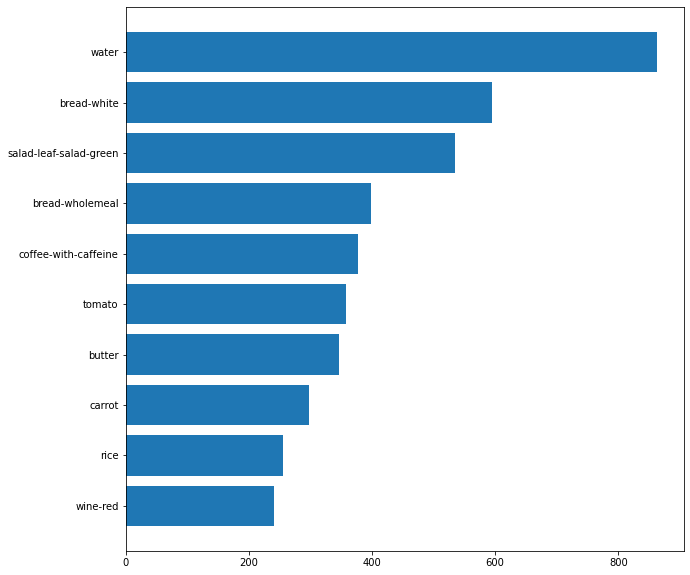

55 	 9.26 %
41 	 1.18 %
12 	 0.9 %
44 	 5.74 %
23 	 2.24 %
13 	 3.71 %
9 	 6.38 %
1 	 2.05 %
22 	 0.94 %
57 	 1.31 %


In [6]:
num = train_file['ClassName'].value_counts()
classes = train_file['ClassName'].unique()
print("Percentage of each class")
print (str(len(classes))+" classes from a total of "+str(train_file.shape[0])+ " images")
# print (num.index)
num.sort_values()
new_num = num[:10][::-1]
plt.figure(figsize=(10,10))
plt.barh(enc.inverse_transform(new_num.index),new_num.values)
plt.show()

for cl in classes[:10]:
    perc = num[cl]/ntrain.shape[0]*100
    print(cl,'\t',float(round(perc,2)),"%")

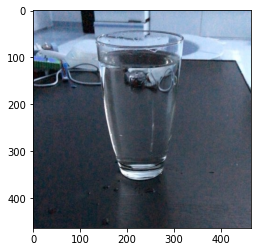

In [7]:
train_data.dispImg(0)

In [8]:
valid_size = 0.2
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(valid_size*len(train_data))
train_idx= indices[split:]
valid_idx = indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch, sampler = valid_sampler)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
### Basic model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16*61*61,120,1)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
#         x = F.relu(self.conv3(x))
        x = x.view(-1, 16*61*61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())
print (model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(59536, 120, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [11]:
def process_img_target(images,device):
    data = images['gt'].squeeze(0).to(device)
    target = images['label'].to(device)
    return data,target

In [12]:
n_epochs = 3
train_losses = []
valid_losses = []

def train(model,optimizer,device,valid_loss_min,train_losses,valid_losses):
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_size = len(train_loader.sampler)
        valid_size = len(valid_loader.sampler)

        model.train()
        print ("Training here...\n")
        for images in tqdm(train_loader):
            data,target = process_img_target(images,device)
            optimizer.zero_grad()
            output = model(data)
            loss = error(output,target)
            loss.backward()
            optimizer.step()
            loss_shape = data.size(0)
            train_loss += loss.item()*loss_shape 
        model.eval()
        print ("Validation here...\n")
        for images in tqdm(valid_loader):
            data,target = process_img_target(images,device)
            output = model(data)
            loss = error(output, target)
            loss_shape = data.size(0)
            valid_loss += loss.item()*loss_shape

        train_loss = train_loss/train_size
        valid_loss = valid_loss/valid_size

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: ',epoch,'\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'best_model_so_far.pth')

train(model,optimizer,device,np.Inf,[],[])

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.777477 	Validation Loss: 3.528793
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.383483 	Validation Loss: 3.288016
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]

Epoch:  2 	Training Loss: 3.118461 	Validation Loss: 3.148541


In [13]:
def test(model):
    model.load_state_dict(torch.load('best_model_so_far.pth'))
    model.eval()
    pred_list = []
    correct_list = []
    with torch.no_grad():
        for images in valid_loader:
            data,target = process_img_target(images,device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            pr = predicted.detach().cpu().numpy()
            for i in pr:
                pred_list.append(i)
            tg = target.detach().cpu().numpy()
            for i in tg:
                correct_list.append(i)
    return correct_list,pred_list
correct_list, pred_list = test(model)

In [14]:
from sklearn.metrics import f1_score 
print("F1 score :",f1_score(correct_list,pred_list,average='micro'))

F1 score : 0.22103004291845493


## With different optimizer

### SGD

In [15]:
optimizer2 = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
train(model,optimizer2,device,np.Inf,[],[])
correct_list1, pred_list1 = test(model)
print("F1 score :",f1_score(correct_list1,pred_list1,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.522755 	Validation Loss: 3.379089
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.048353 	Validation Loss: 3.421443
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch:  2 	Training Loss: 2.766572 	Validation Loss: 3.267820
F1 score : 0.20332618025751073


### AdaGrad

In [16]:
optimizer3 = optim.Adagrad(model.parameters(),lr=0.01,lr_decay=0)
train(model,optimizer3,device,np.Inf,[],[])
correct_list2, pred_list2 = test(model)
print("F1 score :",f1_score(correct_list2,pred_list2,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.496264 	Validation Loss: 3.416125
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 2.213142 	Validation Loss: 3.467013
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch:  2 	Training Loss: 1.547179 	Validation Loss: 3.883711
F1 score : 0.20600858369098712


### RMSprop

In [17]:
optimizer4 = optim.Adagrad(model.parameters())
train(model,optimizer4,device,np.Inf,[],[])
correct_list3, pred_list3 = test(model)
print("F1 score :",f1_score(correct_list3,pred_list3,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 2.861911 	Validation Loss: 3.459856
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 1.603665 	Validation Loss: 3.992379
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch:  2 	Training Loss: 0.849542 	Validation Loss: 4.480363
F1 score : 0.21244635193133046


## With different pooling strategies

### Average Pooling instead of Max Pooling

In [18]:
class Net1(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.conv3 = nn.Conv2d(16*61*61,120,1)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
#         x = F.relu(self.conv3(x))
        x = x.view(-1, 16*61*61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model1 = Net1().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model1.parameters())
print (model1)

Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(59536, 120, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [19]:
train(model1,optimizer,device,np.Inf,[],[])
correct_list4, pred_list4 = test(model1)
print("F1 score :",f1_score(correct_list4,pred_list4,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.672322 	Validation Loss: 3.410857
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.275338 	Validation Loss: 3.224737
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch:  2 	Training Loss: 3.016325 	Validation Loss: 3.121915
F1 score : 0.22424892703862662


## With BatchNorm

In [20]:
class Net2(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch= nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.batch(x))
        x = self.pool2(x)
        x = x.view(-1, 16*61*61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model2 = Net2().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model2.parameters())
print (model2)

Net2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [21]:
train(model2,optimizer,device,np.Inf,[],[])
correct_list5, pred_list5 = test(model2)
print("F1 score :",f1_score(correct_list5,pred_list5,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 4.276991 	Validation Loss: 3.662476
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.445422 	Validation Loss: 3.361998
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch:  2 	Training Loss: 3.198108 	Validation Loss: 3.227511
F1 score : 0.21512875536480686


## With DropOut

In [22]:
class Net3(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*61*61)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model3 = Net3().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model3.parameters())
print (model3)

Net3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [23]:
train(model3,optimizer,device,np.Inf,[],[])
correct_list6, pred_list6 = test(model3)
print("F1 score :",f1_score(correct_list6,pred_list6,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.736603 	Validation Loss: 3.495693
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.354335 	Validation Loss: 3.279802
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch:  2 	Training Loss: 3.130481 	Validation Loss: 3.085606
F1 score : 0.23068669527896996


## With different activation functions

### Only Sigmoid

In [24]:
class Net4(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool2(x)
        x = x.view(-1, 16*61*61)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

model4 = Net4().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model4.parameters())
print (model4)

Net4(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [25]:
train(model4,optimizer,device,np.Inf,[],[])
correct_list7, pred_list7 = test(model4)
print("F1 score :",f1_score(correct_list7,pred_list7,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.848559 	Validation Loss: 3.782647
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.791898 	Validation Loss: 3.780285
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch:  2 	Training Loss: 3.789432 	Validation Loss: 3.779187
F1 score : 0.09227467811158799


### Only tanh

In [26]:
class Net5(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool2(x)
        x = x.view(-1, 16*61*61)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model5 = Net5().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model5.parameters())
print (model5)

Net5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [27]:
train(model5,optimizer,device,np.Inf,[],[])
correct_list8, pred_list8 = test(model5)
print("F1 score :",f1_score(correct_list8,pred_list8,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.731442 	Validation Loss: 3.555855
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.412106 	Validation Loss: 3.280978
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch:  2 	Training Loss: 3.203773 	Validation Loss: 3.192385
F1 score : 0.22210300429184548


### Only LeakyReLU

In [28]:
class Net6(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net6, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
    
    def lrelu(self,x):
        outx = torch.max(0.2 * x, x)
        return outx
    
    def forward(self, x):
      # Forward pass
        x = self.lrelu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.pool2(x)
        x = x.view(-1, 16*61*61)
        x = self.lrelu(self.fc1(x))
        x = self.lrelu(self.fc2(x))
        x = self.fc3(x)
        return x

model6 = Net6().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model6.parameters())
print (model6)

Net6(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=61, bias=True)
)


In [29]:
train(model6,optimizer,device,np.Inf,[],[])
correct_list9, pred_list9 = test(model6)
print("F1 score :",f1_score(correct_list9,pred_list9,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.602436 	Validation Loss: 3.267361
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.056517 	Validation Loss: 3.173267
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch:  2 	Training Loss: 2.568003 	Validation Loss: 3.117205
F1 score : 0.23015021459227467


## Adding new layers

In [30]:
class Net7(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net7, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, 5)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 84)
        self.fc4 = nn.Linear(84, 61)
    
    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
#         print (x.shape)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
#         print (x.shape)
        x = x.view(-1, 8* 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model7 = Net7().to(device)
error = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model7.parameters())
print (model7)

Net7(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=61, bias=True)
)


In [31]:
train(model7,optimizer,device,np.Inf,[],[])
correct_list10, pred_list10 = test(model7)
print("F1 score :",f1_score(correct_list10,pred_list10,average='micro'))

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.852198 	Validation Loss: 3.765646
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.724556 	Validation Loss: 3.611447
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


Epoch:  2 	Training Loss: 3.577979 	Validation Loss: 3.507795
F1 score : 0.15236051502145923


## Basic Augmentation like Rotation, Translation, Color Change

In [32]:
test_data1 = aug_transforms(2,test_file,test_path,False)
test_loader1 = DataLoader(test_data1, batch_size=batch, shuffle=False)

n_epochs = 3

train_data1 = aug_transforms(2,ntrain,train_path,True)
indices1 = list(range(len(train_data1)))
np.random.shuffle(indices1)
split1 = int(valid_size*len(train_data1))
train_idx1= indices1[split1:]
valid_idx1 = indices1[:split1]

train_sampler1 = SubsetRandomSampler(train_idx1)
valid_sampler1 = SubsetRandomSampler(valid_idx1)

train_loader1 = DataLoader(train_data1, batch_size = batch, sampler = train_sampler1)
valid_loader1 = DataLoader(train_data1, batch_size = batch, sampler = valid_sampler1)


def train1(model,optimizer,device,valid_loss_min,train_losses,valid_losses):
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_size = len(train_loader1.sampler)
        valid_size = len(valid_loader1.sampler)

        model.train()
        print ("Training here...\n")
        for images in tqdm(train_loader1):
            data,target = process_img_target(images,device)
            optimizer.zero_grad()
            output = model(data)
            loss = error(output,target)
            loss.backward()
            optimizer.step()
            loss_shape = data.size(0)
            train_loss += loss.item()*loss_shape 
        model.eval()
        print ("Validation here...\n")
        for images in tqdm(valid_loader1):
            data,target = process_img_target(images,device)
            output = model(data)
            loss = error(output, target)
            loss_shape = data.size(0)
            valid_loss += loss.item()*loss_shape

        train_loss = train_loss/train_size
        valid_loss = valid_loss/valid_size

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: ',epoch,'\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'best_model_so_far.pth')

train1(model,optimizer,device,np.Inf,[],[])

  0%|          | 0/59 [00:00<?, ?it/s]

Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  0 	Training Loss: 3.833256 	Validation Loss: 3.811476
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



  0%|          | 0/59 [00:00<?, ?it/s]

Epoch:  1 	Training Loss: 3.858082 	Validation Loss: 3.810259
Training here...



  0%|          | 0/15 [00:00<?, ?it/s]

Validation here...



100%|██████████| 15/15 [00:44<00:00,  2.95s/it]

Epoch:  2 	Training Loss: 3.839104 	Validation Loss: 3.828555


In [33]:
def test1(model):
    model.load_state_dict(torch.load('best_model_so_far.pth'))
    model.eval()
    pred_list = []
    correct_list = []
    with torch.no_grad():
        for images in valid_loader1:
            data,target = process_img_target(images,device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            pr = predicted.detach().cpu().numpy()
            for i in pr:
                pred_list.append(i)
            tg = target.detach().cpu().numpy()
            for i in tg:
                correct_list.append(i)
    return correct_list,pred_list
correct_list11, pred_list11 = test1(model)
print("F1 score :",f1_score(correct_list11,pred_list11,average='micro'))

F1 score : 0.14699570815450644
